In [4]:
import pandas as pd
import datetime

In [5]:
#First we should cehck the Autocorrelation of APPL Stock since we are using a regression model
df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Open","Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]
df


,Date,Close
0,1984-09-07,0.423880
1,1984-09-10,0.421340
2,1984-09-11,0.429020
3,1984-09-12,0.416180
4,1984-09-13,0.439270
...,...,...
9392,2021-12-16,172.259995
9393,2021-12-17,171.139999
9394,2021-12-20,169.750000
9395,2021-12-21,172.990005


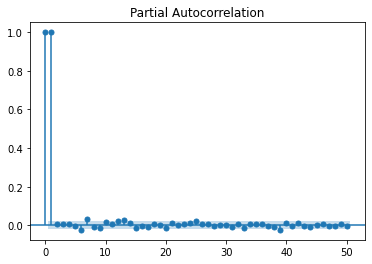

In [9]:
#use PACF to find ideal P value
#we will just use the closing values for now
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plot_pacf(train["Close"], lags=50)
plt.show()

We can see that the stock price is correlated strongly at a time lag of 1, (ie yesterdays price) howevever there is not much correlation between the price of two days ago. In the AFC plot you will see the correlation from the prevouse day carry over.

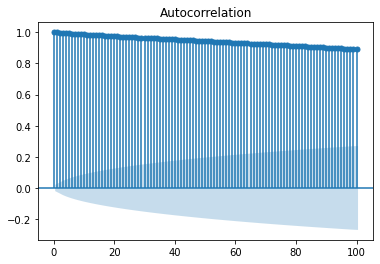

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df["Close"], lags= 100)
plt.show()

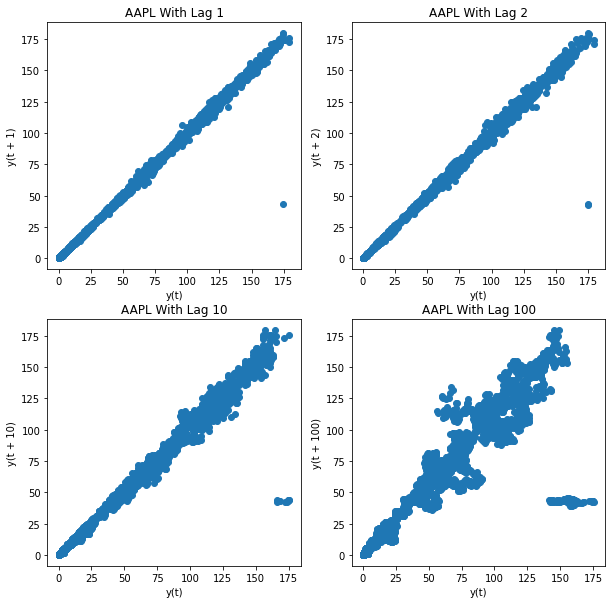

In [27]:
from pandas.plotting import lag_plot


fig, axes = plt.subplots(nrows=2, ncols=2, figsize= (10,10))
lag_plot(df["Close"], lag=1, ax=axes[0,0])
lag_plot(df["Close"], lag=2, ax=axes[0,1])
lag_plot(df["Close"], lag=10, ax=axes[1,0])
lag_plot(df["Close"], lag=100, ax=axes[1,1])
axes[0,0].title.set_text("AAPL With Lag 1")
axes[0,1].title.set_text("AAPL With Lag 2")
axes[1,0].title.set_text("AAPL With Lag 10")
axes[1,1].title.set_text("AAPL With Lag 100")

plt.show()

In [7]:
#build the AR Model with lag 1
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn.metrics import mean_squared_error
from math import sqrt

model = AutoReg(train["Close"], lags = 10, old_names=False)
model_fit = model.fit()
print(model_fit.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                 9151
Model:                    AutoReg(10)   Log Likelihood              -17148.038
Method:               Conditional MLE   S.D. of innovations              1.579
Date:                Fri, 31 Dec 2021   AIC                              0.917
Time:                        16:23:30   BIC                              0.926
Sample:                            10   HQIC                             0.920
                                 9151                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0252      0.020      1.269      0.204      -0.014       0.064
Close.L1       0.9991      0.010     95.526      0.000       0.979       1.020
Close.L2       0.0077      0.015      0.522      0.6

In [29]:
pred = model_fit.predict(start=len(train)+1, end=len(train)+1 ,dynamic=False)
pred.iloc[0]

132.62463971006224

c:\Users\BrianBeinBrohan\projects\pytorch tutorials\env\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


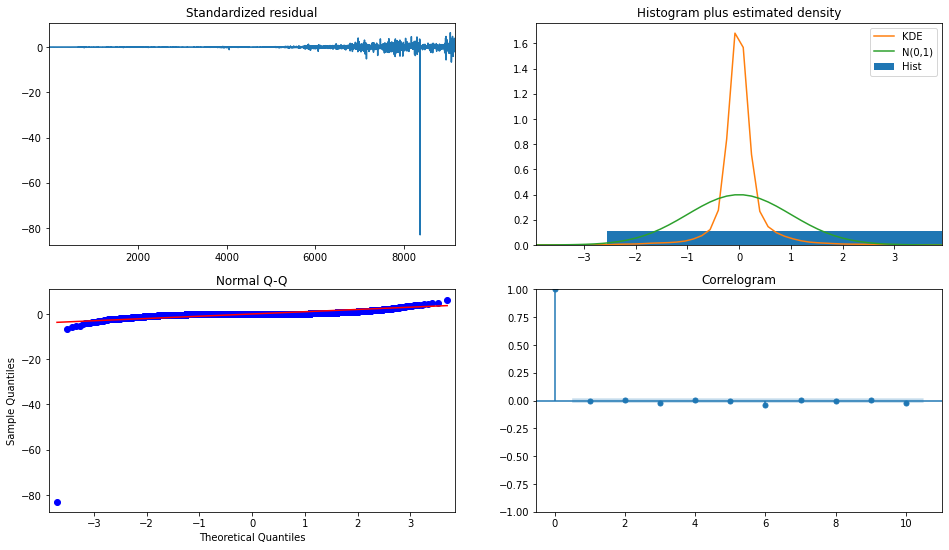

In [30]:
fig = plt.figure(figsize=(16, 9))
fig = model_fit.plot_diagnostics(fig=fig, lags=10)

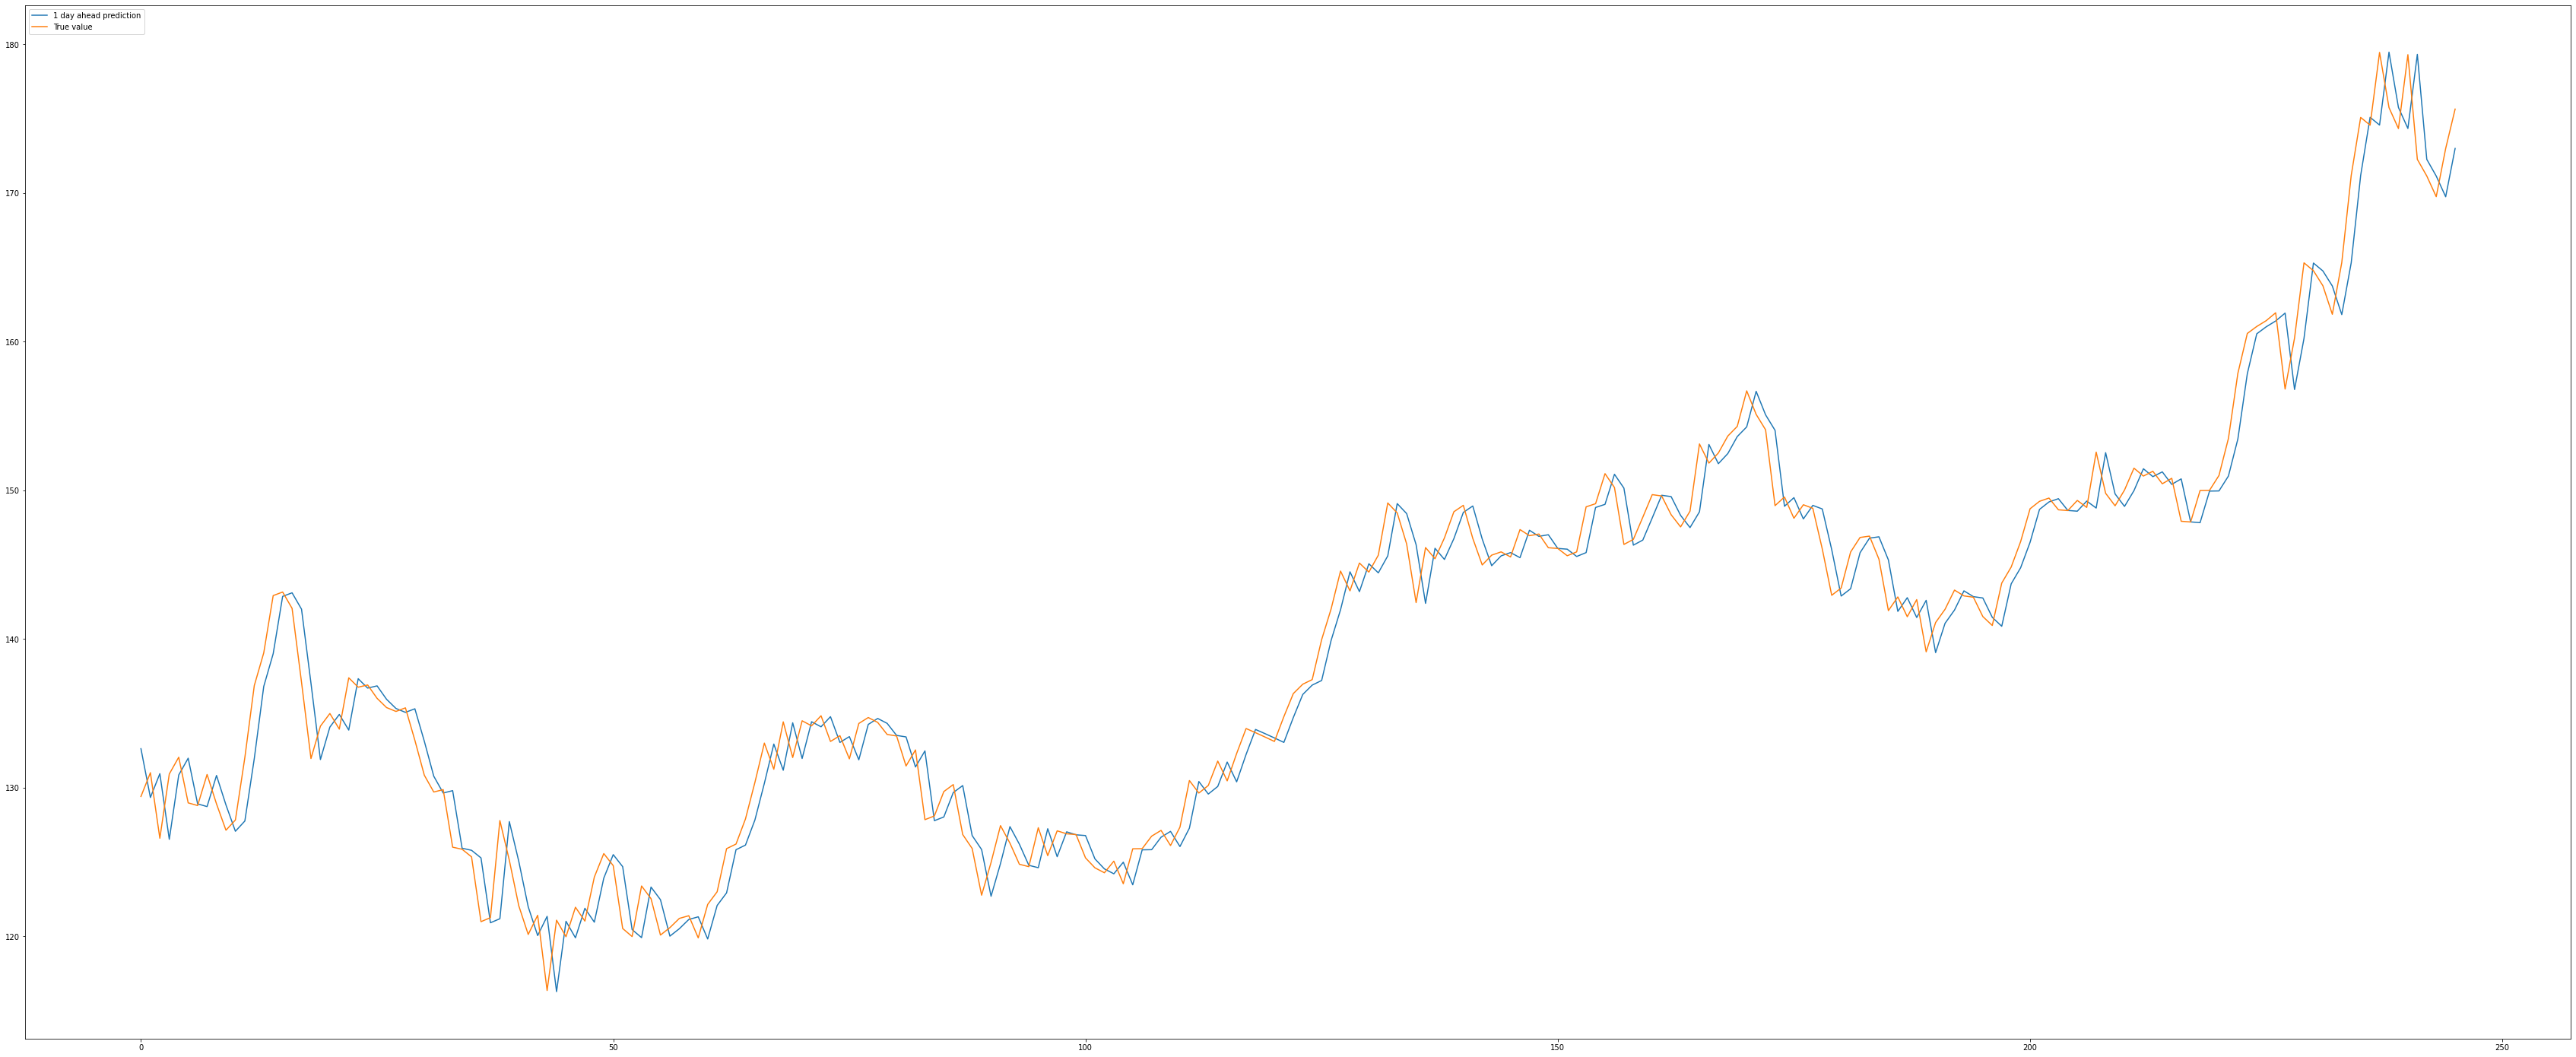

In [11]:
#now there seems to be a problem here? What is it, well we are trying to predict a years worth of data using data from a year ago, essnetially 100+ time lags back, so
#we have to keep updating the model each time lag

#First we should cehck the Autocorrelation of APPL Stock since we are using a regression model
df = pd.read_csv("../data/processed/appl_stock_values.csv")

#split the data
df["Date"] = pd.to_datetime(df["Date"])
df = df.drop(columns=["Open","Volume", "High", "Low", "Unnamed: 0"])
test = df[df["Date"] > datetime.datetime(2021, 1, 1)]
train = df[df["Date"] <= datetime.datetime(2021, 1, 1)]
lag_1_pred = []
#lag_2_pred = []
date = []

test = test.reset_index(drop=True)

for i in range(len(test)):
    model = AutoReg(train["Close"], lags = 1, old_names=False)
    model_fit = model.fit()
    lag_1_pred.append(model_fit.predict(start=len(train)+1, end=len(train)+ 1).iloc[0])
    #lag_2_pred.append(model_fit.predict(start=len(train)+1, end=len(train) +2).iloc[1])

    date.append(test.iloc[i]["Date"])
    train = train.append({"Close": test.iloc[i]["Close"], "Date":test.iloc[i]["Date"]}, ignore_index=True)

plt.figure(figsize=(60,25))
plt.plot(lag_1_pred, label = "1 day ahead prediction")
plt.plot(test["Close"], label = "True value")
plt.legend(loc="upper left")
plt.show()

    



In [32]:
#lets check the error for a better comparison
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
mean_squared_error(lag_1_pred, test["Close"].values.tolist())
mean_absolute_percentage_error(lag_1_pred, test["Close"].values.tolist())


0.012335442849194541

In [33]:
#note on the error, if we notice that since one of the graphs is predicting a day ahead
for i in range(len(lag_1_pred)-1):
    print(lag_1_pred[i+1] ,test["Close"].iloc[i]) 

mean_squared_error(lag_1_pred[1::], test["Close"].iloc[0:len(test)-1].values.tolist())

129.34158525933074 129.410004
130.94303399688962 131.009995
126.5293366909235 126.599998
130.852779640356 130.919998
131.98389528716288 132.050003
128.91114125203296 128.979996
128.73106169878008 128.800003
130.82287894550183 130.889999
128.8412138648197 128.910004
127.06987601898551 127.139999
127.76045194261751 127.830002
131.96397436800817 132.029999
136.80898999607317 136.869995
139.01172502740414 139.070007
142.86694458905612 142.919998
143.10736200692392 143.160004
142.00580782612656 142.059998
137.02921380036236 137.089996
131.8936817819512 131.960007
134.07583659072696 134.139999
134.92679006620298 134.990005
133.87574317944694 133.940002
137.32949677095107 137.389999
136.6988170626809 136.759995
136.84905863320964 136.910004
135.9480854386928 136.009995
135.3274684218641 135.389999
135.06725527177596 135.130005
135.30756150545778 135.369995
133.1253605699501 133.190002
130.77321436225404 130.839996
129.64232698808678 129.710007
129.80250428560868 129.869995
125.92961882467347 

0.0031572903322642978

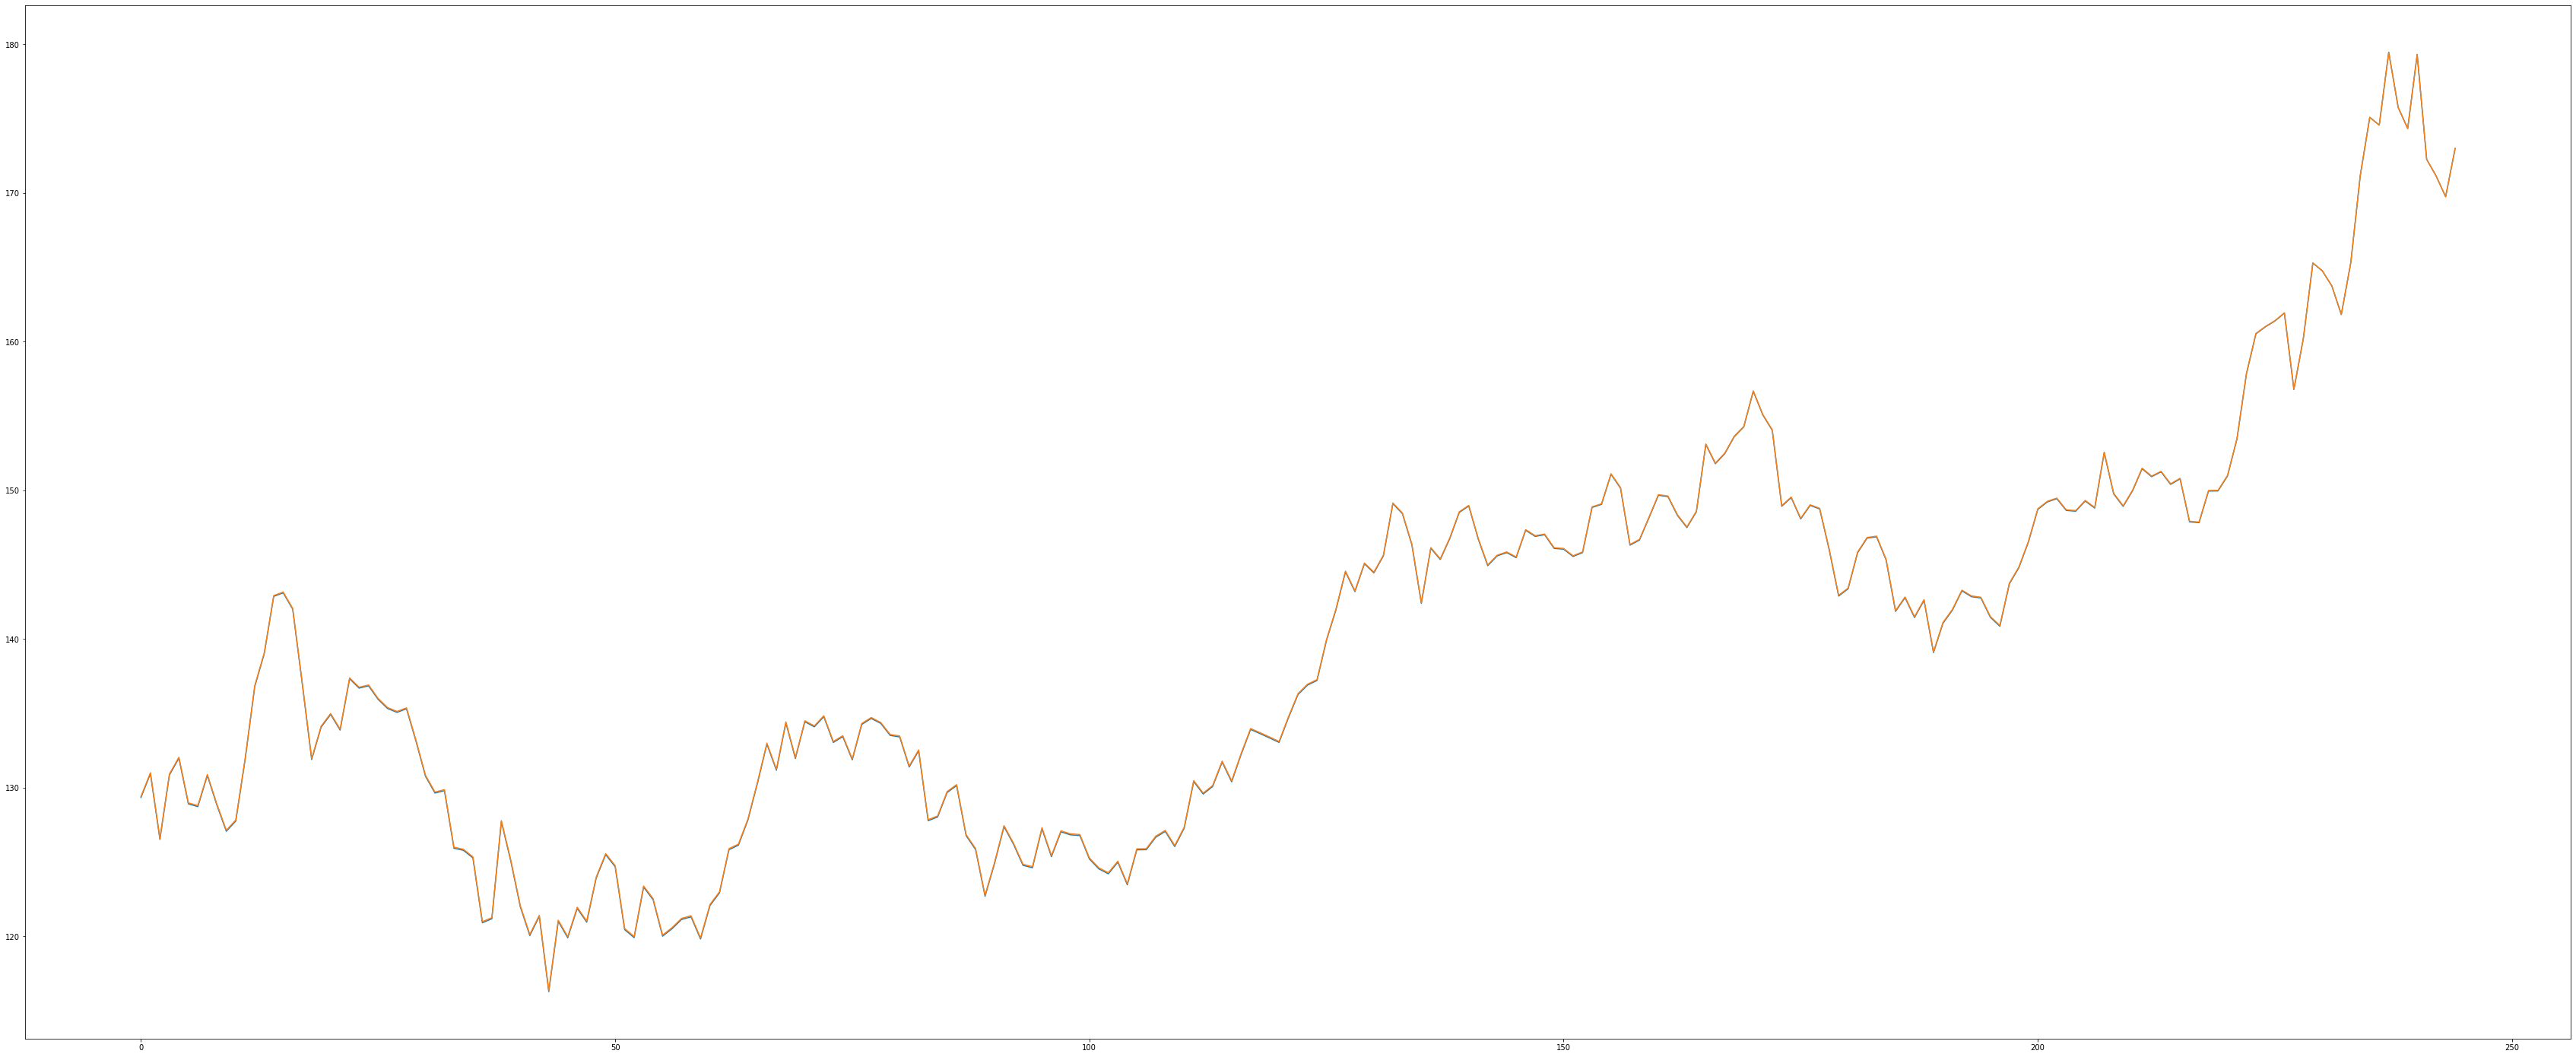

In [34]:
plt.figure(figsize=(60,25))
plt.plot(lag_1_pred[1::])
plt.plot(test["Close"].iloc[0:len(test)-1])
plt.show()

we can see that is predicts almost perfectly, but this raises some sus, how about we test with different stocks, maybe some with lower correlations. Also by sheer forgetfullness I did not perform any differencing on this model. Lets see if differencing it changes anything